In [3]:
# train_tfidf_dt.py

import re
import pickle
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.corpus import stopwords

# Download stopwords and prepare stopword set
nltk.download("stopwords", quiet=True)
stops = set(stopwords.words("indonesian") + stopwords.words("english"))

# Prepare Indonesian stemmer
factory = StemmerFactory()
stemmer = nltk.stem.SnowballStemmer("english")

# Load and filter hoax news
hoax = pd.read_csv(
    "../Dataset/hoax_news.csv",
    usecols=["Title", "Narasi", "category"]
).dropna(subset=["Title", "Narasi", "category"])
hoax = hoax[~hoax["category"].isin(["Benar", "Disinformasi"])]
hoax = hoax.rename(columns={"Title": "title", "Narasi": "body"})
hoax["label"] = "hoax"

# Load and label real news
real = pd.read_csv(
    "../Dataset/detik_news.csv",
    usecols=["page", "title", "url", "content"]
).dropna(subset=["title", "content"])
real = real.rename(columns={"content": "body"})
real["label"] = "real"
real = real[["title", "body", "label"]]

# Remove outliers from hoax based on text length
for field in ["title", "body"]:
    lengths = hoax[field].str.len()
    q1, q3 = lengths.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    hoax = hoax[(lengths >= lower) & (lengths <= upper)]
hoax = hoax.drop(columns=["category"])

# Balance the dataset by downsampling to the smaller class
df = pd.concat([hoax, real], ignore_index=True)
min_size = df["label"].value_counts().min()
df = df.groupby("label", group_keys=False).apply(
    lambda g: g.sample(min_size, random_state=42)
)

# Split into training, validation, and test sets (70/20/10)
X = df[["title", "body"]].astype(str)
y = df["label"]
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)
val_fraction = 0.2 / 0.9
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_fraction, stratify=y_temp, random_state=42
)

# Function to clean, tokenize, and stem text
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if t not in stops and len(t) > 1]
    return [stemmer.stem(t) for t in tokens]

# Apply preprocessing to each split
for subset in (X_train, X_val, X_test):
    subset["text"] = (
        subset["title"].apply(clean_tokenize).apply(" ".join)
        + " "
        + subset["body"].apply(clean_tokenize).apply(" ".join)
    )

# Convert text to TF-IDF features limited to 1000 tokens
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train["text"])
X_val_tfidf   = vectorizer.transform(X_val["text"])
X_test_tfidf  = vectorizer.transform(X_test["text"])

# Perform feature masking augmentation (40% masked)
mask_probability = 0.40
rng = np.random.default_rng(42)
base_array = X_train_tfidf.toarray()
mask = rng.binomial(1, 1 - mask_probability, size=base_array.shape)
augmented_array = base_array * mask

X_train_final = np.vstack([base_array, augmented_array])
y_train_final = np.hstack([y_train.values, y_train.values])

# Train Decision Tree classifier
print("Training")
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_final, y_train_final)

# Evaluate on validation set
val_preds = dt_model.predict(X_val_tfidf.toarray())
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds, digits=3))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, val_preds, labels=["hoax", "real"]))

# Evaluate on test set
test_preds = dt_model.predict(X_test_tfidf.toarray())
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print(classification_report(y_test, test_preds, digits=3))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, test_preds, labels=["hoax", "real"]))

# Save the pipeline to file
with open("dt_tfidf_aug_hoax.pkl", "wb") as f:
    pickle.dump({
        "model":       dt_model,
        "vectorizer":  vectorizer,
        "stopwords":   stops,
        "mask_prob":   mask_probability,
        "stemmer":     stemmer
    }, f)

print("Saved TF-IDF+DecisionTree pipeline to dt_tfidf_aug_hoax.pkl")


Training
Validation Accuracy: 0.9713392391870767
              precision    recall  f1-score   support

        hoax      0.983     0.959     0.971       959
        real      0.960     0.983     0.972       960

    accuracy                          0.971      1919
   macro avg      0.972     0.971     0.971      1919
weighted avg      0.972     0.971     0.971      1919

Validation Confusion Matrix:
[[920  39]
 [ 16 944]]
Test Accuracy: 0.9676746611053181
              precision    recall  f1-score   support

        hoax      0.985     0.950     0.967       480
        real      0.952     0.985     0.968       479

    accuracy                          0.968       959
   macro avg      0.968     0.968     0.968       959
weighted avg      0.968     0.968     0.968       959

Test Confusion Matrix:
[[456  24]
 [  7 472]]
Saved TF-IDF+DecisionTree pipeline to dt_tfidf_aug_hoax.pkl


OOD Results for TF-IDF + Decision Tree
Accuracy: 0.56
              precision    recall  f1-score   support

        hoax      0.549     0.975     0.703        80
        real      0.750     0.086     0.154        70

    accuracy                          0.560       150
   macro avg      0.650     0.530     0.428       150
weighted avg      0.643     0.560     0.447       150



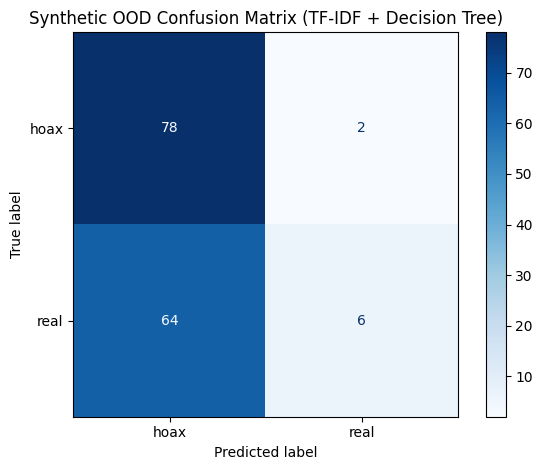

In [4]:
# test_tfidf_dt_synthetic.py

import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# load the TF-IDF + Decision Tree pipeline
with open("dt_tfidf_aug_hoax.pkl", "rb") as f:
    data       = pickle.load(f)
    dt_model   = data["model"]
    vectorizer = data["vectorizer"]
    stops      = data["stopwords"]
    stemmer    = data["stemmer"]

# define the same cleaning & tokenization used during training
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if t not in stops and len(t) > 1]
    return [stemmer.stem(t) for t in tokens]

# load the synthetic OOD dataset (tab-separated: title, body, label)
titles, bodies, true_labels = [], [], []
with open("../Dataset/synthetic_news.txt", "r", encoding="utf-8") as f:
    for line in f:
        t, b, lab = line.strip().split("\t")
        titles.append(t)
        bodies.append(b)
        true_labels.append(lab)

# preprocess and join title + body for each sample
texts = [
    " ".join(clean_tokenize(t) + clean_tokenize(b))
    for t, b in zip(titles, bodies)
]

# vectorize into TF-IDF features and convert to dense array
X_syn = vectorizer.transform(texts).toarray()

# predict on the synthetic OOD set
preds = dt_model.predict(X_syn)

# print overall accuracy and classification report
print("OOD Results for TF-IDF + Decision Tree")
print("Accuracy:", accuracy_score(true_labels, preds))
print(classification_report(true_labels, preds, digits=3))

# display the confusion matrix
cm = confusion_matrix(true_labels, preds, labels=["hoax", "real"])
disp = ConfusionMatrixDisplay(cm, display_labels=["hoax", "real"])
disp.plot(cmap="Blues")
plt.title("Synthetic OOD Confusion Matrix (TF-IDF + Decision Tree)")
plt.tight_layout()
plt.show()
